In [1]:
import numpy as np
import pylab
#import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv('hcc-data-complete-balanced.csv') #cargamos tabla
data

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,...,ALP,TP,Creatinine,Nodule,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
0,1,0,1,0,0,0,0,1,0,1,...,150,7.1,0.70,1,3.5,0.50,52.5,37.0,856.0,1
1,0,0,0,0,0,0,1,1,0,1,...,120,7.0,0.58,1,1.8,0.85,32.0,10.0,18.0,1
2,1,0,1,1,0,1,0,1,0,1,...,109,7.0,2.10,5,13.0,0.10,28.0,6.0,16.0,1
3,1,1,1,0,0,0,0,1,0,1,...,174,8.1,1.11,2,15.7,0.20,131.0,78.0,1316.0,0
4,1,1,1,1,0,1,0,1,0,1,...,109,6.9,1.80,1,9.0,0.10,59.0,15.0,22.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0,0,0,0,0,0,1,1,0,0,...,117,7.0,5.25,2,8.8,1.35,73.3,46.0,873.0,0
200,0,1,1,0,0,0,0,1,0,0,...,231,6.5,0.78,2,7.6,1.04,69.3,23.0,70.0,0
201,1,1,1,0,0,0,0,1,0,0,...,304,7.0,1.07,1,12.0,1.57,71.2,29.0,106.0,0
202,1,1,1,0,0,0,0,1,0,0,...,197,7.2,1.08,5,3.0,0.63,94.4,83.0,859.0,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

Obtenemos los subconjuntos de datos

In [4]:
X = data.drop(['Class'], axis=1) 
y=data['Class']
#x_train, x_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

(204, 49)

In [5]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):

    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''

    mse = []
    component = np.arange(1, n_comp)

    for i in component:
        pls = PLSRegression(n_components=i)

        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)

        mse.append(mean_squared_error(y, y_cv))

        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)

        plt.show()

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)

    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')

        plt.show()

    return

122% completed
Suggested number of components:  6



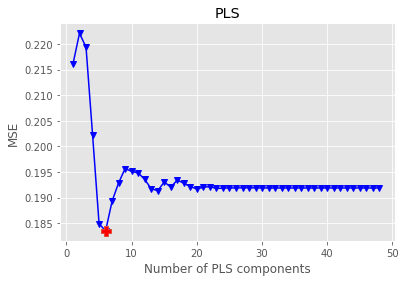

R2 calib: 0.620
R2 CV: 0.266
MSE calib: 0.095
MSE CV: 0.183


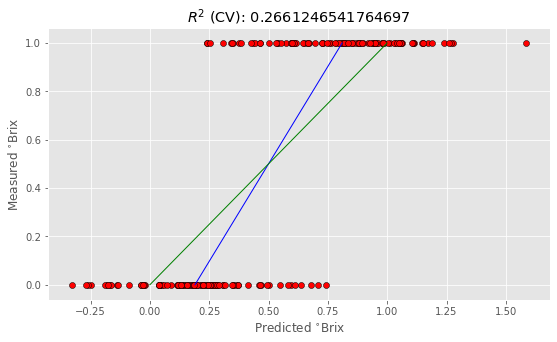

In [6]:
optimise_pls_cv(X,y, 49, plot_components=True)